# Twitter Sentiment Analysis
## Problem Statement
With the rapid growth of social media, platforms such as Twitter have emerged as critical conduits for users to express their opinions and feedback. Understanding public sentiment, especially for businesses, can significantly impact marketing strategies, customer service improvements, and product development. However, due to the unstructured and large nature of the data, manually analysing such information is inefficient and lacks scalability.

## Objective
This project aims to create a machine-learning model that can accurately perform sentiment analysis on Twitter data. The model will classify a given tweet into four categories:
*   Positive
*   Negative
*   Neutral
*   Irrelevant

## Dataset
The dataset used in this project is the Twitter Sentiment Analysis Kaggle project, uploaded by Passionate-NLP. The dataset can be found [here](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/data)

There are 2 files in the dataset:

*   twitter_training.csv: used for model training
*   twitter_validation.csv: used for model evaluation






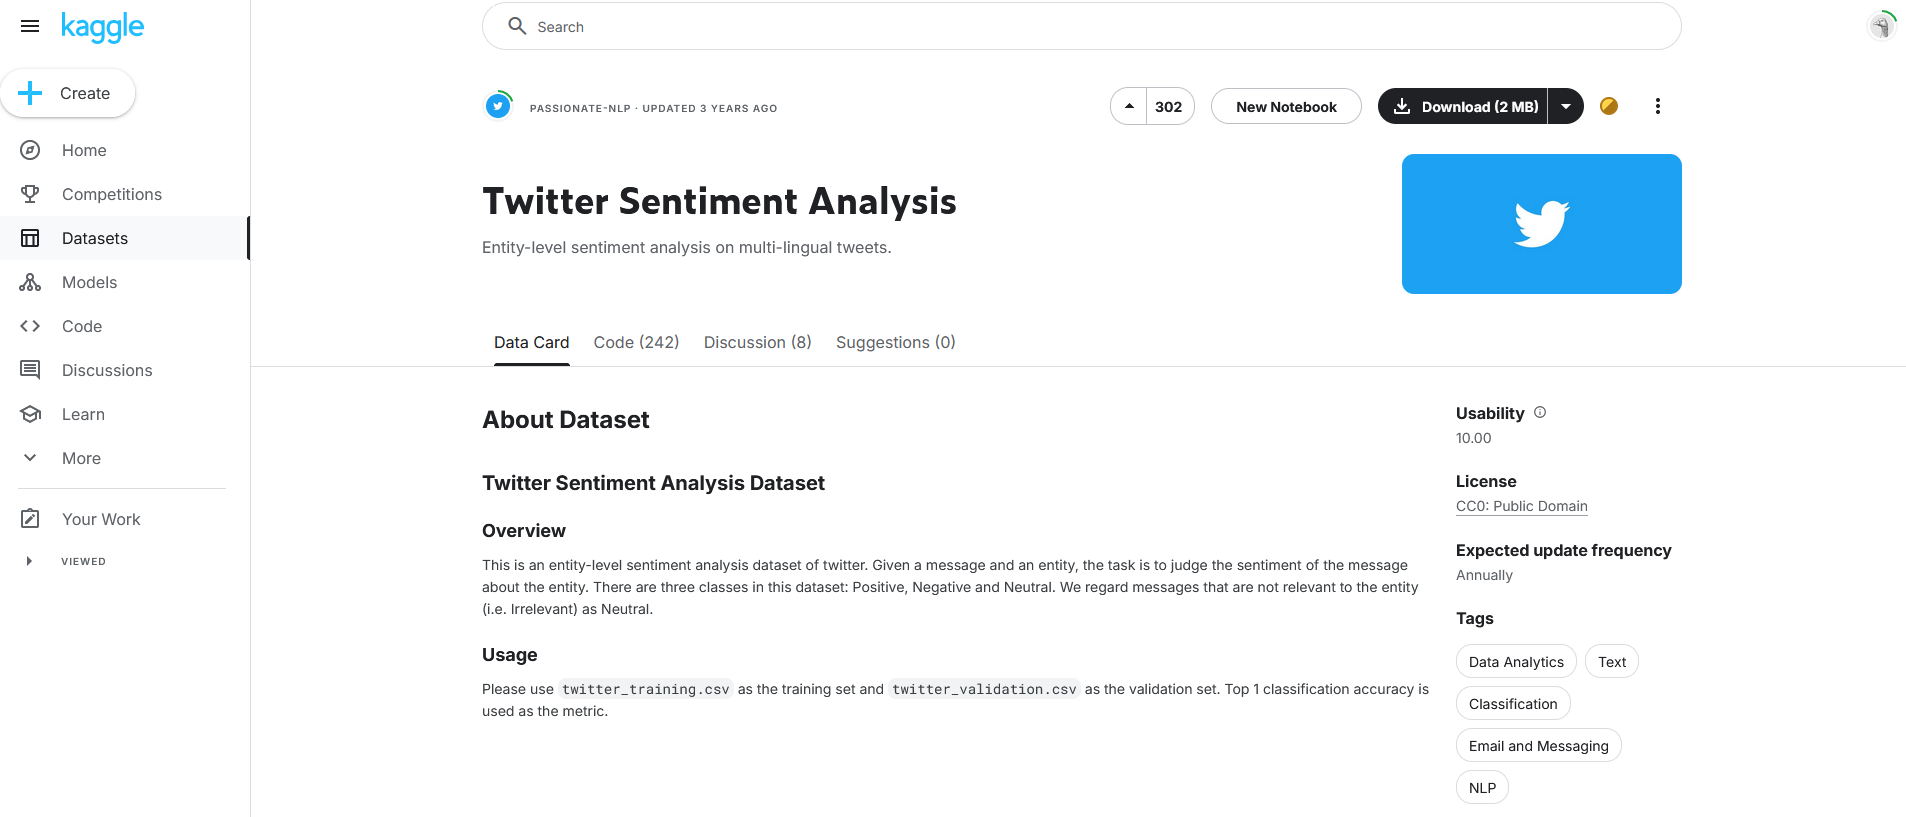

# Master Control
Change the following boolean variables to activate certain behaviour in the code
It is recommended to load the preprocessed training & validation data, because it can take a long time to do the preprocessing task.

As a baseline, it took 6 hours to complete preprocessing the training data with a machine that has 8 workers

In [3]:
#Master control
LOAD_PREPROCESSED_TRAINING_DATA = True
LOAD_PREPROCESSED_VALIDATION_DATA = True
SAVE_MODELS = False
LOAD_MODELS = False

# Prepare Google Collab Environment

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
import os
os.chdir("/content/drive/MyDrive/Twitter_Sentiment_Analysis")
os.getcwd()

'/content/drive/MyDrive/Twitter_Sentiment_Analysis'

In [5]:
!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
import kaggle

In [7]:
!mkdir -p ./dataset
!mkdir -p ./processed_dataset/
!mkdir -p ./models
os.chdir("./dataset")
os.getcwd()

'/content/drive/MyDrive/Twitter_Sentiment_Analysis/dataset'

Loading the dataset from Kaggle

In [8]:
!kaggle datasets download -d jp797498e/twitter-entity-sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis
License(s): CC0-1.0
twitter-entity-sentiment-analysis.zip: Skipping, found more recently modified local copy (use --force to force download)


In [9]:
!unzip /content/drive/MyDrive/ADA/Twitter_Sentiment_Analysis/dataset/twitter-entity-sentiment-analysis.zip

Archive:  /content/drive/MyDrive/ADA/Twitter_Sentiment_Analysis/dataset/twitter-entity-sentiment-analysis.zip
replace twitter_training.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: twitter_training.csv    
replace twitter_validation.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: twitter_validation.csv  


In [10]:
os.chdir("..")
os.getcwd()

'/content/drive/MyDrive/Twitter_Sentiment_Analysis'

Installing required libraries

In [12]:
!pip install pandarallel
!pip install pyspellchecker
!pip install spacy
!pip install contractions
!pip install graphviz
!pip install pydotplus

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 11.1 MB/s eta 0:00:00


# Libraries

In [13]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import time

import re
import string
import nltk
import joblib
import contractions
from pandarallel import pandarallel
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from joblib import parallel_backend
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectFromModel

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Step 1 Load Dataset

In [14]:
# read data
df = pd.read_csv('./dataset/twitter_training.csv')
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column                                                 Non-Null Count  Dtype 
---  ------                                                 --------------  ----- 
 0   2401                                                   74681 non-null  int64 
 1   Borderlands                                            74681 non-null  object
 2   Positive                                               74681 non-null  object
 3   im getting on borderlands and i will murder you all ,  73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


## Step 1.1 Remove and Rename Column

In [16]:
# Remove unnecessary columns
df = df.drop('2401', axis=1)

# Rename columns
df.columns=['Topic','Sentiment','Tweet']
df.head()

,Topic,Sentiment,Tweet
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,Borderlands,Positive,im coming on borderlands and i will murder you...
3,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,Borderlands,Positive,im getting into borderlands and i can murder y...


## Step 1.2 Check Missing Values

In [17]:
# check missing values
print(df.isnull().sum())

Topic          0
Sentiment      0
Tweet        686
dtype: int64


In [18]:
# remove missing values
df.dropna(inplace=True)
# check missing values
df.isnull().sum()

,0
Topic,0
Sentiment,0
Tweet,0


## Step 1.3 Check Duplicate Values

In [19]:
# check duplicate values
df.duplicated().sum()

3038

In [20]:
# remove duplicate values
df = df.drop_duplicates()
# check duplicate values
df.duplicated().sum()

0

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 70957 entries, 0 to 74680
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Topic      70957 non-null  object
 1   Sentiment  70957 non-null  object
 2   Tweet      70957 non-null  object
dtypes: object(3)
memory usage: 2.2+ MB


In [22]:
# show the number of tweets in each sentiment
df["Sentiment"].value_counts()

,count
Sentiment,
Negative,21565
Positive,19548
Neutral,17398
Irrelevant,12446


# Step 2 EDA

## Step 2.1 Pie and Bar Plot

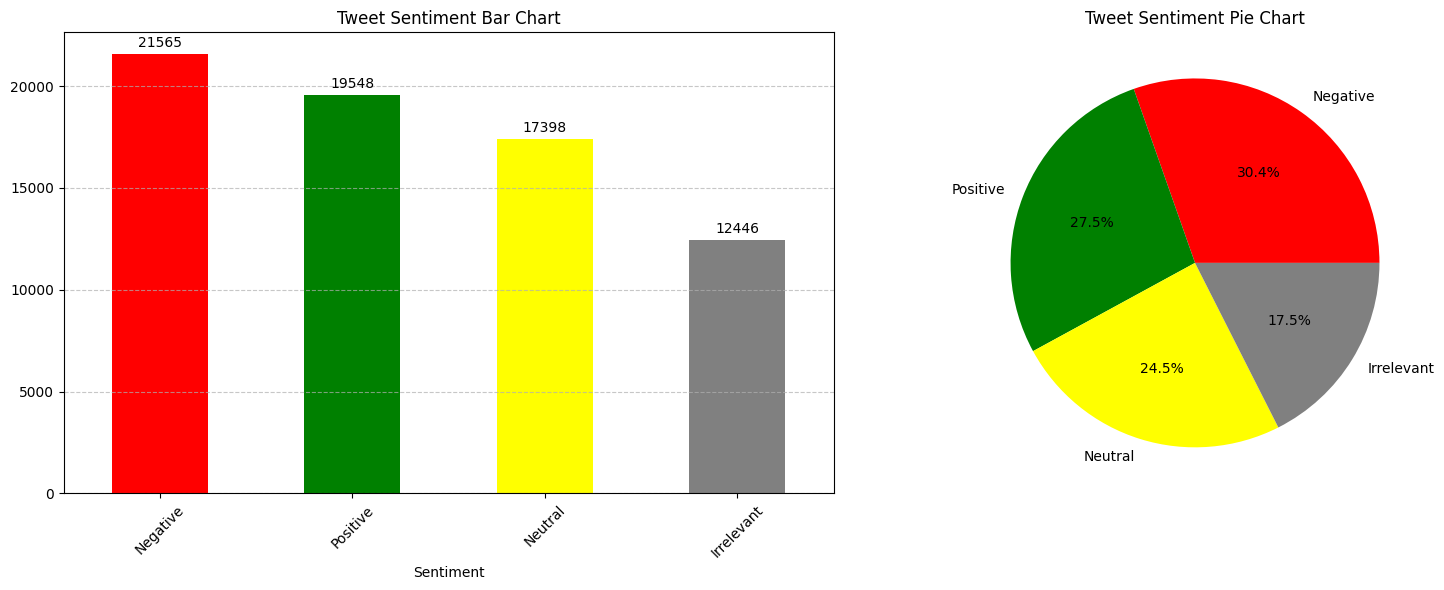

In [23]:
# Define custom colors
colors = ['red', 'green', 'yellow', 'gray']

# Get the sentiment counts and labels in the correct order
sentiment_counts = df['Sentiment'].value_counts()
sentiment_labels = sentiment_counts.index

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plotting bar plot for sentiment distribution
axs[0] = sentiment_counts.plot(kind='bar', color=colors, ax=axs[0])
axs[0].set_title('Tweet Sentiment Bar Chart')
axs[0].tick_params(axis='x', rotation=45)
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

for p in axs[0].patches:
    axs[0].annotate(f'{int(p.get_height())}',   # The label (height of the bar)
                    (p.get_x() + p.get_width() / 2., p.get_height()),  # Position of the label
                    ha='center', va='center', xytext=(0, 8),  # Offset to position the label a bit higher
                    textcoords='offset points', fontsize=10)

# Plotting pie chart for sentiment distribution with custom colors
axs[1].pie(sentiment_counts, labels=sentiment_labels, autopct='%1.1f%%',
            colors=colors)
axs[1].set_title('Tweet Sentiment Pie Chart')

plt.tight_layout()
plt.show()

## Step 2.2 Cross Table

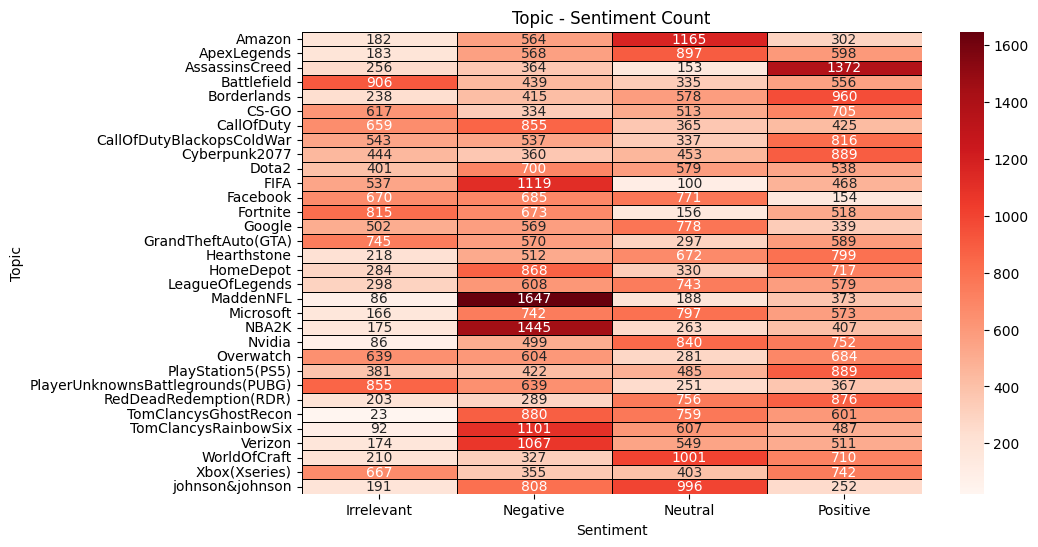

In [24]:
# count number of tweets in each sentiment & topic
plt.figure(figsize=(10, 6))
count_table = pd.crosstab(index=df['Topic'], columns=df['Sentiment'])
sns.heatmap(count_table, cmap='Reds', annot=True, fmt='d', linewidths=0.5, linecolor='black')
plt.title('Topic - Sentiment Count')
plt.show()

In [25]:
# Display minimum and maximum values for each sentiment for each Topic
for sentiment in count_table.columns:
    min_Topic = count_table[sentiment].idxmin()
    max_Topic = count_table[sentiment].idxmax()
    min_val = count_table[sentiment].min()
    max_val = count_table[sentiment].max()
    print(f"Sentiment '{sentiment}':")
    print(f"  Minimum value '{min_val}' at Topic '{min_Topic}'")
    print(f"  Maximum value '{max_val}' at Topic '{max_Topic}'\n")


Sentiment 'Irrelevant':
  Minimum value '23' at Topic 'TomClancysGhostRecon'
  Maximum value '906' at Topic 'Battlefield'

Sentiment 'Negative':
  Minimum value '289' at Topic 'RedDeadRedemption(RDR)'
  Maximum value '1647' at Topic 'MaddenNFL'

Sentiment 'Neutral':
  Minimum value '100' at Topic 'FIFA'
  Maximum value '1165' at Topic 'Amazon'

Sentiment 'Positive':
  Minimum value '154' at Topic 'Facebook'
  Maximum value '1372' at Topic 'AssassinsCreed'



## Step 2.3 Word Cloud

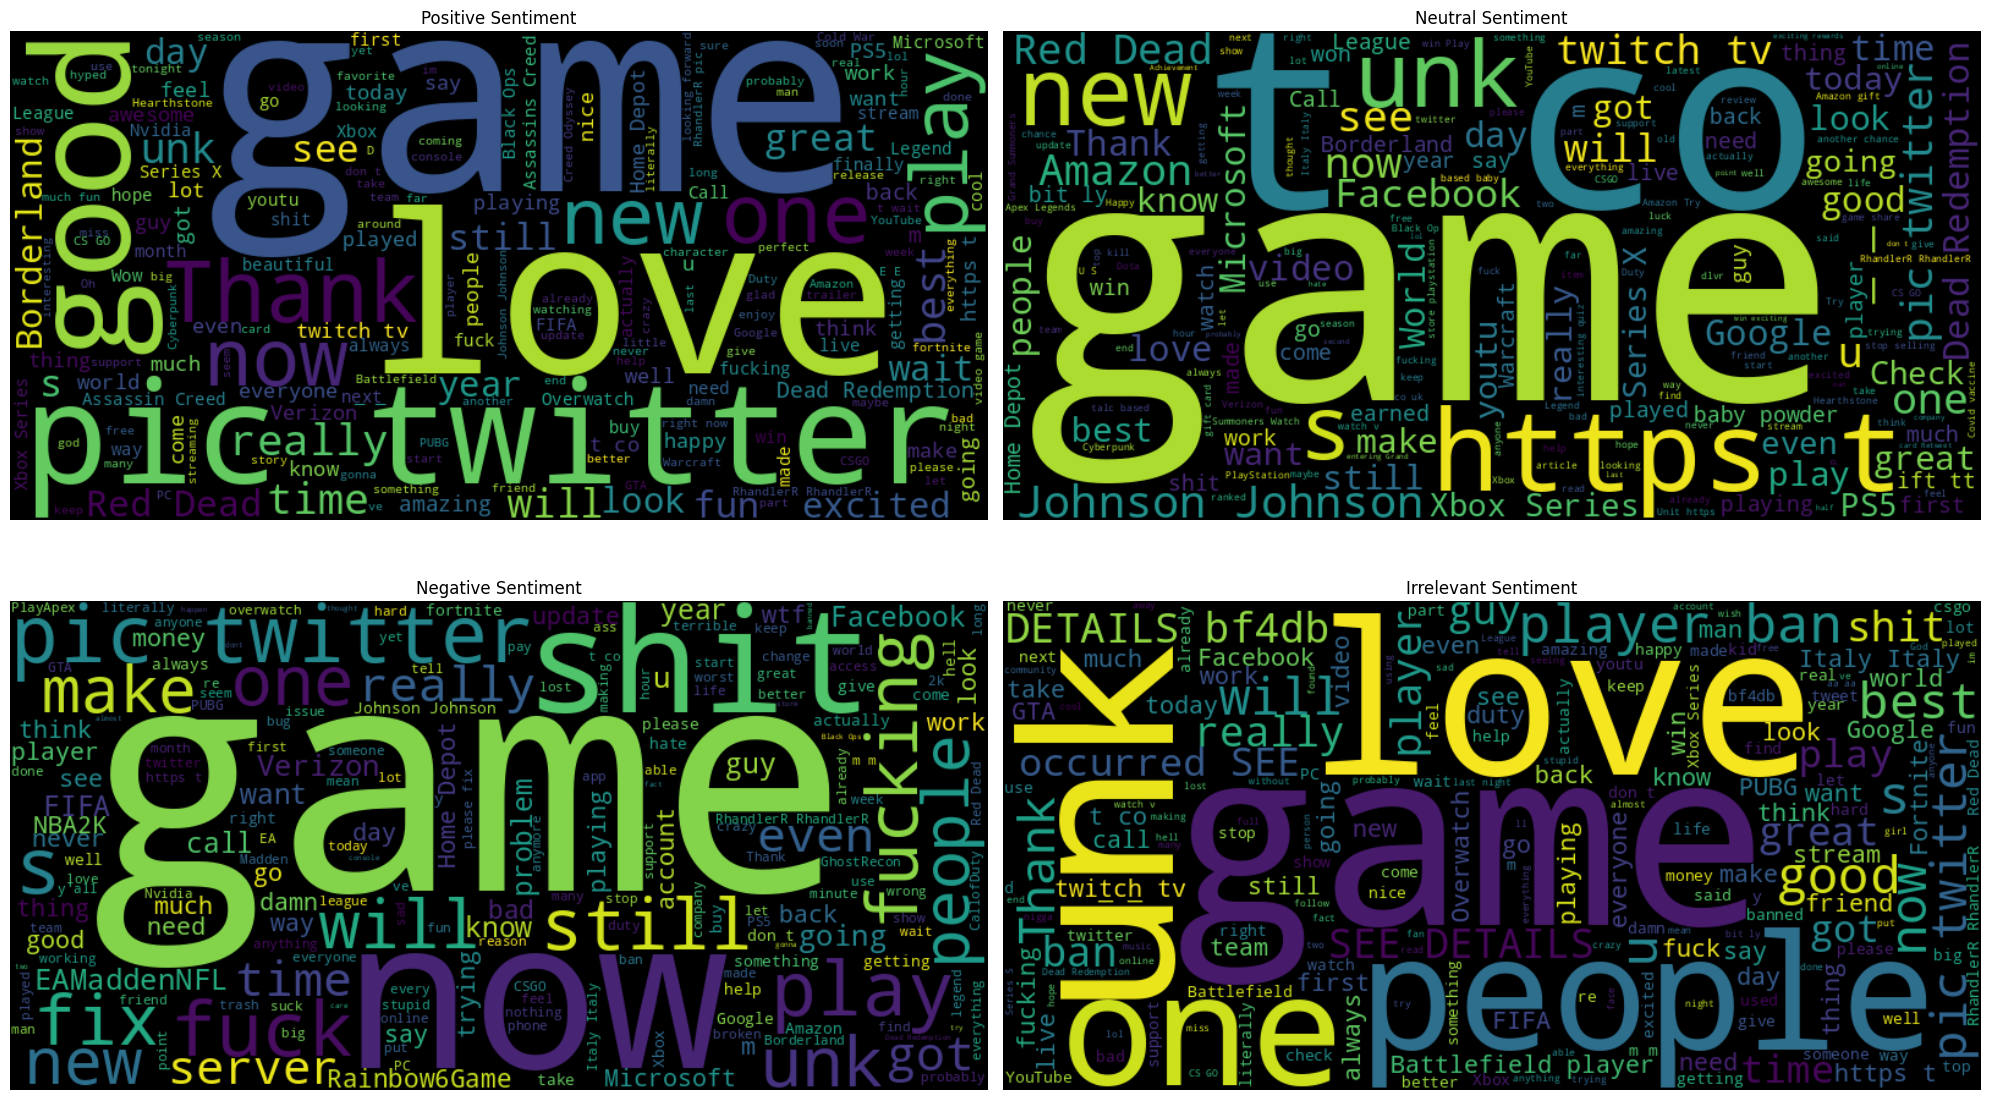

In [26]:
# Create a function to generate and display a word cloud for each sentiment
def create_wordcloud(df, sentiment, ax):
    tweets_text = ' '.join(df[df['Sentiment'] == sentiment]['Tweet'])
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(tweets_text)

    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"{sentiment} Sentiment")
    ax.axis('off')

# Set up the subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Generate word clouds for each sentiment
create_wordcloud(df, 'Positive', axes[0, 0])
create_wordcloud(df, 'Neutral', axes[0, 1])
create_wordcloud(df, 'Negative', axes[1, 0])
create_wordcloud(df, 'Irrelevant', axes[1, 1])

# Show the plot
plt.tight_layout()
plt.show()

## Step 2.4 URL Analysis

The URL inside the “Tweet” column was found to be unstructured. Some URLs may contain spaces between “/” or are not prefixed by https. Additional data-cleaning efforts will need to be performed to handle this issue.

In [27]:
with pd.option_context('display.max_colwidth', None):
    filtered_df = df[df['Tweet'].str.contains('https', case=False, na=False)]
    print(filtered_df["Tweet"][:10])

287                                                                                          Modern Warfare For $38, Borderlands 3 For $20, And More Great Game Deals (PS4, Xbox One, Switch) unsorted.co/modern-warfare… https://t.co/2n68qoJKhU
288                                                                                      Modern Warfare for $38, Borderlands 3 for $20 and other great games (PS4, Xbox One, Switch) unsorted.co / modern-warfare... https: / / t.co / 2n68qoJKhU
290                                                                                        Modern Warfare Not $38, Borderlands For For $20, All More Great Game Gear (PS4, Xbox One, Switch) unsorted.co/modern-warfare… https://t.co/2n68qoJKhU]
291                           Modern Warfare 11 For $ 38, Borderlands 3 For $ 20, 200 And More Great Nintendo Game Group Deals ( PS4, Xbox One, Nintendo Switch ) also unsorted. See co / w modern - warfare database … https://t.co/2n68qoJKhU ]
383     Pretty Happy with this! 

## Step 2.5 Emoji Analysis

An analysis of the number of emojis in the “Tweet” column reveals that only 839 tweets contain emojis or 1.2% of the dataset. As a result, removing emojis entirely will have minimal impact on the training data of this model.

In [28]:
# Function to find emojis
def find_emojis(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"  # checkmarks and hand gestures
                               u"\U000024C2-\U0001F251"  # enclosed alphanumerics and various symbols.
                               u"\U0001f926-\U0001f937"  # emoji showing a person gesture
                               u"\U00010000-\U0010ffff"  # plane and private use areas.
                               u"\u2640-\u2642"          # Gender symbols (female and male signs).
                               u"\u2600-\u2B55"          # Various symbols including weather, astrological signs, and geometric shapes.
                               u"\u200d"                 # Zero Width Joiner (used in emoji sequences).
                               u"\u23cf"                 # Eject symbol.
                               u"\u23e9"                 # Fast-forward button.
                               u"\u231a"                 # Watch symbol
                               u"\ufe0f"                 # dingbats
                               u"\u3030"                 # Wavy dash.
                               u"\u30FB"                 # ・
                               u"\uFF80"                 # ｦ
                               "]+", flags=re.UNICODE)
    return emoji_pattern.findall(text)

# Apply the function to find emojis
df['Tweet'].apply(find_emojis).value_counts()

,count
Tweet,
[],70118
[🤣],66
[🥺],54
[🤔],47
"[🤦, ‍]",45
...,...
"[🤸, ‍, 🤸, ‍, 🤸, ‍]",1
"[🤷‍, 🤷‍, 🤷‍, 🤷‍, 🤷‍]",1
"[🤣🤦, ‍]",1


# Step 3 Preprocessing

## Step 3.1 Convert to lower case

Converts all character to lower case, to ensure uniformity and minimise vocabulary size.  

In [29]:
def to_lower_case(text):
    return text.lower()


## Step 3.2 Remove HTML Tags

Removes html tags from text like \<p\>, \<br\>, or \<a href\>

In [30]:
def remove_html_tags(text):
    pattern = re.compile('<.*?>')
    return pattern.sub('', text)

## Step 3.3 Remove URL

Remove URL or Hyperlinks from the text since they are often irrelevant to sentiment analysis

In [31]:
def remove_urls(text):
    pattern=re.compile(r'http\S+|www\S+|pic\.\S+|[a-zA-Z]+\s*\.\s*[a-zA-Z]+\s*/?\s*\S*')
    return pattern.sub(r'',text)

## Step 3.4 Remove Emoji

Removes Emoji from the text

In [32]:
def remove_emojis(text):
    if isinstance(text, str):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"  # checkmarks and hand gestures
                               u"\U000024C2-\U0001F251"  # enclosed alphanumerics and various symbols.
                               u"\U0001f926-\U0001f937"  # emoji showing a person gesture
                               u"\U00010000-\U0010ffff"  # plane and private use areas.
                               u"\u2640-\u2642"          # Gender symbols (female and male signs).
                               u"\u2600-\u2B55"          # Various symbols including weather, astrological signs, and geometric shapes.
                               u"\u200d"                 # Zero Width Joiner (used in emoji sequences).
                               u"\u23cf"                 # Eject symbol.
                               u"\u23e9"                 # Fast-forward button.
                               u"\u231a"                 # Watch symbol
                               u"\ufe0f"                 # dingbats
                               u"\u3030"                 # Wavy dash.
                               u"\u30FB"                 # ・
                               u"\uFF80"                 # ｦ
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    else:
        return text


## Step 3.5 Remove Numbers

Remove Digits/Numbers from text, because numbers are often irrelevant to sentiment analysis

In [33]:
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

## Step 3.6 Remove Extra Space

Remove extra space from the text

In [34]:
def remove_extra_space(text):
    return ' '.join(text.split())

## Step 3.7 Remove Punctuations

Remove Punctuation marks like periods, commas, or exclamation marks as they are often irrelevant to sentiment analysis


In [35]:
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

## Step 3.8 Spellchecking

Use pyspellcheck library to correct any spelling mistake in the text, or return the word as is

In [36]:
def correct_spelling(text):
    from spellchecker import SpellChecker

    spell = SpellChecker()
    words = text.split()  # Tokenize the text into words
    corrected_words = []
    for word in words:
        correction = spell.correction(word)
        if correction:  # If correction is found, use it
            corrected_words.append(correction)
        else:  # Otherwise, use the original word
            corrected_words.append(word)
    return ' '.join(corrected_words)


## Step 3.9 Remove Contractions

Converts contractions like 'don't' or 'can't' to their expanded form 'do not' and 'cannot'  
Intrestingly, the contractions library can recognize contractions without their punctuation mark (e.g. dont is recognised as don't)

In [37]:
def remove_contractions(text):
    return contractions.fix(text)

## Step 3.12 Lemmatization

Lemmatization is a process in NLP that involves reducing words to their base or dictionary form, called a lemma.   
The goal of lemmatization is to normalize words by converting them to a common form so that words with similar meanings are grouped together.  
  
For example, the words “running”, “ran”, and “runs” will be converted to "run"

In [38]:
def lemmatize_words(text):
    import spacy
    lemma = spacy.load('en_core_web_sm')
    doc = lemma(text)
    return [token.lemma_ for token in doc]

## Step 3.11 Remove Stop Words

Stop words are commonly used words like "the," "is," or "and" that don't carry much meaning and can be removed to reduce noise in the data.

In [39]:
def remove_stopwords(tokens):
    from nltk.corpus import stopwords
    stop_words = set(stopwords.words('english'))
    filtered_words = []
    for word in tokens:
        if word.lower() not in stop_words:
            filtered_words.append(word)

    return filtered_words

## Step 3.12 Preprocess Data

one challenge with preprocessing the training data is how long it takes to run the entire pipeline. In a machine with 8 workers, it took about 6 hours. So, running the pipeline again is time-consuming and expensive.

In [40]:
pandarallel.initialize(progress_bar=True)

# Preprocessing pipeline
def preprocess_text(df):
    df['Tweet'] = df['Tweet'].apply(to_lower_case)
    df['Tweet'] = df['Tweet'].apply(remove_html_tags)
    df['Tweet'] = df['Tweet'].apply(remove_urls)
    df['Tweet'] = df['Tweet'].apply(remove_emojis)
    df['Tweet'] = df['Tweet'].apply(remove_numbers)
    df['Tweet'] = df['Tweet'].apply(remove_extra_space)
    df['Tweet'] = df['Tweet'].apply(remove_punctuation)
    print("start correct_spelling")
    df['Tweet'] = df['Tweet'].parallel_apply(correct_spelling)
    df['Tweet'] = df['Tweet'].apply(remove_contractions)        # Converts contractions like 'don't' or 'can't' to their expanded form 'do not' and 'cannot'
    print("start lemmatize_words")
    df['Tweet'] = df['Tweet'].parallel_apply(lemmatize_words)   # Converts words to their base form, e.g. the words “running”, “ran”, and “runs” will be converted to "run"
    print("start remove_stopwords")
    df['Tweet'] = df['Tweet'].parallel_apply(remove_stopwords)  # Remove commonly used words like "the," "is," or "and" that don't carry much meaning
    return df

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [41]:
if LOAD_PREPROCESSED_TRAINING_DATA:
    df_processed = pd.read_pickle('./processed_dataset/df_processed.pkl')
else:
    df_processed = preprocess_text(df)
    df_processed.to_pickle("./processed_dataset/df_processed.pkl")

In [42]:
df_processed.head(5)

,Topic,Sentiment,Tweet
0,Borderlands,Positive,"[come, border, kill]"
1,Borderlands,Positive,"[get, borderland, kill]"
2,Borderlands,Positive,"[come, borderland, murder]"
3,Borderlands,Positive,"[get, borderland, murder]"
4,Borderlands,Positive,"[get, borderland, murder]"


# Step 4 Build Model


Preparing evaluation function  
  
  The F-1 score measures how well the model handles classification by looking at both precision and recall, rather than just accuracy.   
    
  The weighted F-1 score also accounts for the distribution of each class, which gives a more balanced evaluation. This is especially helpful in sentiment analysis of a Twitter dataset, where the "irrelevant" tweets are fewer than the other categories and might affect the model's accuracy.

In [43]:
def evaluate_model(y_test, y_pred, cf_name, show_confusion_matrix=True):
    # Calculate weighted_f1_score
    weighted_f1_score = f1_score(y_test, y_pred, average='weighted')
    print(f"{cf_name} weighted F1 score:", weighted_f1_score)

    # Print classification report
    print(f"{cf_name} Classification Report:")
    print(classification_report(y_test, y_pred))

    # Create a confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    if show_confusion_matrix:
        # Plot confusion matrix
        labels = ["Irrelevant", "Negative", "Neutral", "Positive"]
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
        plt.title(f"{cf_name} Confusion Matrix")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.show()

## Step 4.1 Training and Test Data Preparation

In [44]:
# After lemmatization, "Tweet" data is stored in token/list form
# convert it back to text string
df_processed['Tweet'] = df_processed['Tweet'].apply(lambda x: ' '.join(x))

X = df_processed['Tweet']
y = df_processed['Sentiment']

# Split data into training and testing sets (80% training, 20% testing)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [45]:
# Print the shapes of the training and testing sets
print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of x_train: (56765,)
Shape of x_test: (14192,)
Shape of y_train: (56765,)
Shape of y_test: (14192,)


In [46]:
# show the distribution of each sentiment in the original, training, and test dataset
print("Original dataset sentiment distribution:")
print(df['Sentiment'].value_counts(normalize=True))

print("\nTraining set sentiment distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set sentiment distribution:")
print(y_test.value_counts(normalize=True))

Original dataset sentiment distribution:
Sentiment
Negative      0.303916
Positive      0.275491
Neutral       0.245191
Irrelevant    0.175402
Name: proportion, dtype: float64

Training set sentiment distribution:
Sentiment
Negative      0.303920
Positive      0.275487
Neutral       0.245186
Irrelevant    0.175407
Name: proportion, dtype: float64

Test set sentiment distribution:
Sentiment
Negative      0.303904
Positive      0.275507
Neutral       0.245209
Irrelevant    0.175380
Name: proportion, dtype: float64


In [47]:
if LOAD_MODELS:
    vectorizer = joblib.load('./models/vectorizer.pkl')
    x_train_tfidf = vectorizer.transform(x_train)
    x_test_tfidf = vectorizer.transform(x_test)

    le = joblib.load('./models/label_encoder.pkl')
    y_train_encoded = le.transform(y_train)
    y_test_encoded = le.transform(y_test)

else:
    # Convert text data to TF-IDF features
    vectorizer = TfidfVectorizer()
    x_train_tfidf = vectorizer.fit_transform(x_train)
    x_test_tfidf = vectorizer.transform(x_test)

    # convert sentiment label to numeric
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)


The resulting TF-IDF data shape shows 56765 rows of test data with 18279 unique vocabularies.  
 This is a high number of vocabulary and raises concerns about overfitting, which will be addressed in the fine-tuning later.

In [48]:
x_train_tfidf.shape

(56765, 18279)

In [49]:
if SAVE_MODELS:
    joblib.dump(le, './models/label_encoder.pkl')
    joblib.dump(vectorizer, './models/vectorizer.pkl')

## Step 4.2 SVC

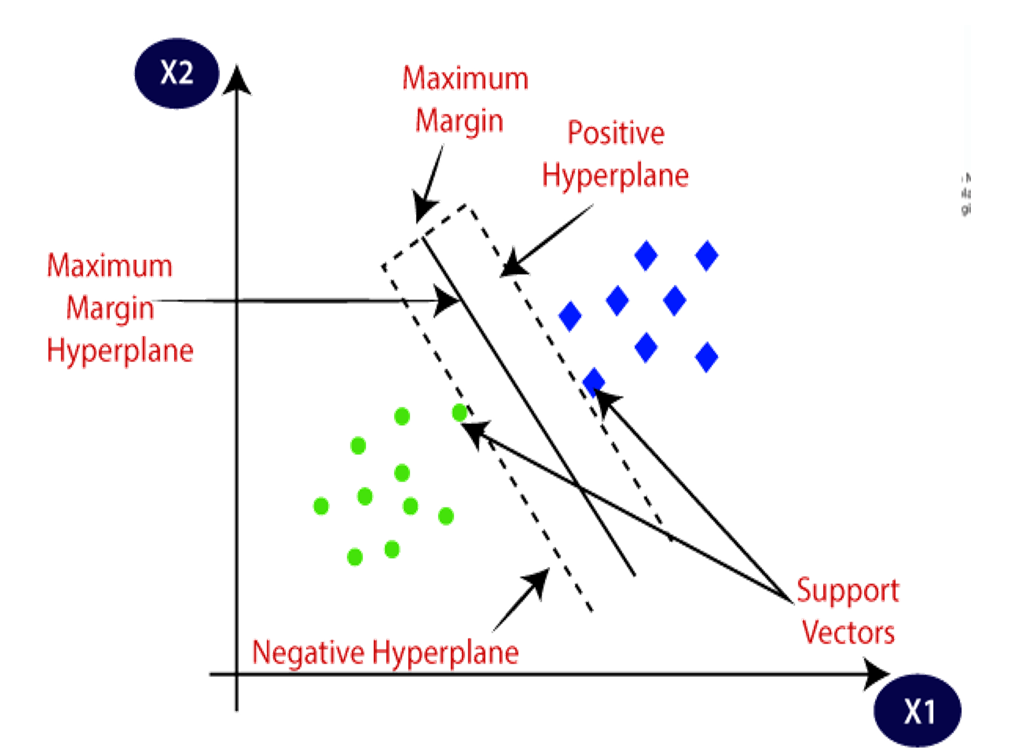

A **Support Vector Classifier (SVC)** is a Support Vector Machine model used in classification machine learning tasks. It works by adding data points to a high-dimensional space and creating hyperplanes that maximise the margin between different classes. The margin is the distance between the hyperplane and the nearest data point, also known as support vectors. In this scenario, the four different classes are: “Positive”, “Negative”, “Neutral”, and “Irrelevant”.

*   The shape of the hyperplane can be determined by its kernel trick. The Twitter Semantic Analysis model uses the **RBF** Kernel because Tweets data are complex and non-linearly separable. This kernel produces highly flexible decision boundaries, allowing it to map non-linear relationships in the dataset.
*   the **C** parameter controls the trade-off between correct classification and misclassification. This introduces a soft margin that allows some misclassification in the hyperplane.
*   The **Gamma** parameter determines the influence of a single data point on the decision boundary. A lower gamma value makes a hyperplane that generalises well but can cause underfitting. A higher gamma value makes a hyperplane that fits the training data very closely, which can result in overfitting.
*   The **class_weight** parameter assigns different weights to each class in the training data. It is helpful to handle data imbalances between different classes and prevent bias towards the majority class.





Hyperparameter tuning using RandomizedSearchCV

**RandomizedSearchCV** combines grid search with cross-validation, but instead of testing every combination, it tries random combinations and evaluates the results. It takes several parameters as input

Best param: {

    'kernel': 'rbf',
    'gamma': 'scale',
    'class_weight': 'balanced',
    'C': 10
    
}  

**Kernel** = RBF  
Gives the model ability to handle non-linear relationships in the data
  
**Gamma** = Scale  
Makes the model automatically scale the gamma based on the number of vocabulary in the training data. This prevents certain gamma values (for example, if explicitly stated) from being too large or too small for a dataset, which can cause underfitting or overfitting.
   
**Class_weight** = Balanced  
Automatically adjust the weight based on the class distribution of the input data. For the Twitter dataset, a higher weight will be given to a sentiment class with fewer data points, like “Irrelevant”.   
   
**C** = 10  
o	A high C value like 10 helps the model capture complex patterns in the data because it is stricter when classifying the training examples.


### Hyper Parameter Tuning

**estimator** = the machine-learning model to be evaluated  
**param_distributions** = the list of hyperparameters to be tested  
**scoring** = the performance metric used to evaluate the hyperparameter combination with the best fit    
**cv** = the cross-validation splitting strategy.   
**n_jobs** = the maximum number of jobs that can run in parallel.
**verbose** = controls the verbosity of the grid search message.  
**n_iter** = the number of hyperparameter combinations to be tested.


params = {
    
    'C': [25, 50, 100, 150, 200],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Different kernel types
    'gamma': ['scale', 'auto'],  # Kernel
    "class_weight": ["balanced"]
}

grid_search = RandomizedSearchCV (estimator=SVC(),
                           param_distributions=params,
                           cv=5, n_jobs=-1, verbose=3, scoring = "f1_weighted, n_iter=5)

with parallel_backend('threading'):  
&emsp;grid_search.fit(x_train_tfidf, y_train_encoded)

best_svc  = grid_search.best_estimator_  
score_df = pd.DataFrame(grid_search.cv_results_)  
score_df.sort_values(by='rank_test_score', inplace=True)  
for i in range(5):  
&emsp;print(f"param {i}: ", score_df.iloc[i]["params"], "  ")  
&emsp;print(f"mean_test_score {i}: ", score_df.iloc[i]["mean_test_score"], "  ")  

### Model Training

In [50]:
if LOAD_MODELS:
    best_svc = joblib.load('./models/best_svc.pkl')
else:
    best_svc = SVC(kernel='rbf', gamma='scale', class_weight='balanced', C=10)
    best_svc.fit(x_train_tfidf, y_train_encoded)

Test SVC weighted F1 score: 0.9163933652977819
Test SVC Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.94      0.89      0.92      2489
    Negative       0.94      0.92      0.93      4313
     Neutral       0.93      0.91      0.92      3480
    Positive       0.87      0.94      0.90      3910

    accuracy                           0.92     14192
   macro avg       0.92      0.91      0.92     14192
weighted avg       0.92      0.92      0.92     14192



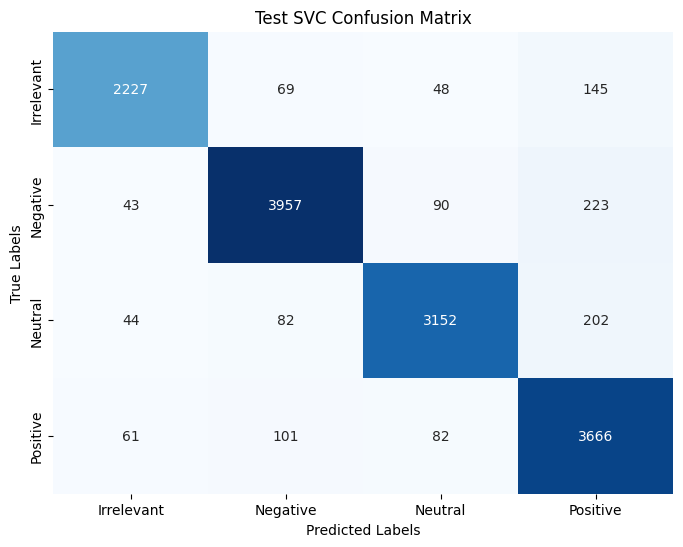

In [51]:
# Predict on the testing data
y_pred_encoded  = best_svc.predict(x_test_tfidf)
y_pred = le.inverse_transform(y_pred_encoded)

evaluate_model(y_test, y_pred, "Test SVC")

In [52]:
if SAVE_MODELS:
    joblib.dump(best_svc, './models/best_svc.pkl')

# Step 5 Predicting Validation Data

set LOAD_MODEL to true to use the precreated models

In [53]:
if LOAD_MODELS:
    vectorizer = joblib.load('./models/vectorizer.pkl')
    le = joblib.load('./models/label_encoder.pkl')
    best_svc = joblib.load('./models/best_svc.pkl')

In [54]:
# read data
df_validation = pd.read_csv('./dataset/twitter_validation.csv')
df_validation.head()

,3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,4433,Google,Neutral,Now the President is slapping Americans in the...
4,6273,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [55]:
# Remove unnecessary columns
df_validation = df_validation.drop('3364', axis=1)

# Rename columns
df_validation.columns=['Topic','Sentiment','Tweet']
df_validation.head()

,Topic,Sentiment,Tweet
0,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
1,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
2,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
3,Google,Neutral,Now the President is slapping Americans in the...
4,FIFA,Negative,Hi @EAHelp I’ve had Madeleine McCann in my cel...


In [56]:
print(df_validation.isnull().sum())
print(df_validation.duplicated().sum())

Topic        0
Sentiment    0
Tweet        0
dtype: int64
0


In [57]:
if LOAD_PREPROCESSED_VALIDATION_DATA:
    df_validation_processed = pd.read_pickle('./processed_dataset/df_validation_processed.pkl')
else:
    df_validation_processed = preprocess_text(df_validation)
    df_validation_processed.to_pickle("./processed_dataset/df_validation_processed.pkl")

In [58]:
# After lemmatization, "Tweet" data is stored in token/list form
# convert it back to text string
df_validation_processed['Tweet'] = df_validation_processed['Tweet'].apply(lambda x: ' '.join(x))

x_validation = df_validation_processed['Tweet']
y_validation = df_validation_processed['Sentiment']

In [59]:
x_validation_tfidf = vectorizer.transform(x_validation)
y_validation_encoded = le.transform(y_validation)

## Step 5.2 Validate SVC

Validation SVC weighted F1 score: 0.9679737563000764
Validation SVC Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.96      0.96      0.96       171
    Negative       0.97      0.97      0.97       266
     Neutral       0.97      0.97      0.97       285
    Positive       0.96      0.97      0.96       277

    accuracy                           0.97       999
   macro avg       0.97      0.97      0.97       999
weighted avg       0.97      0.97      0.97       999



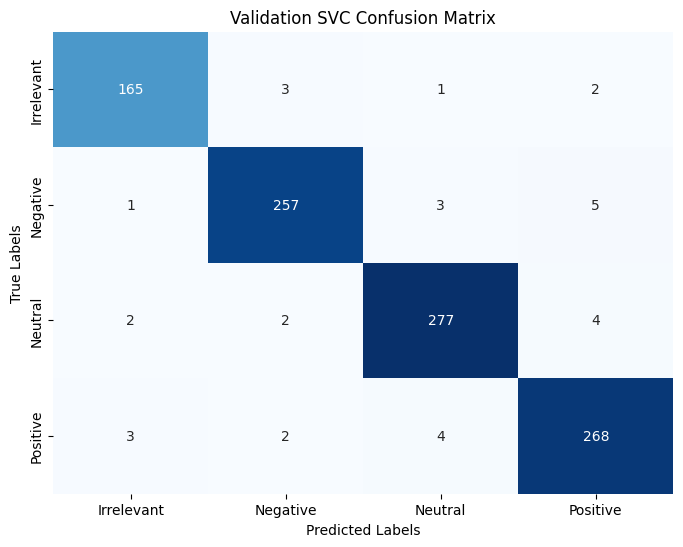

In [60]:
y_validation_pred_encoded  = best_svc.predict(x_validation_tfidf)
y_validation_pred = le.inverse_transform(y_validation_pred_encoded)
evaluate_model(y_validation, y_validation_pred, "Validation SVC")

# Step 6 Fine Tuning

While performing well on testing and validation datasets, the **extensive vocabulary** in the training data raises concerns about overfitting and low performance on future unseen data. However, re-running the pipeline is costly so to address this challenge, **feature selection** will be applied to optimise the model and allow it to focus on the most important pattern of the Twitter dataset.

## Step 6.1 Random Forest Classifier



The first step in feature selection is to optimise a random forest classifier using the training dataset.  

Hyperparameter tuning using RandomizedSearchCV

Best param: {

    'n_estimators': 200,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'max_features': 'log2',
    'max_depth': None,
    'criterion': 'entropy'

    }  

**N_estimators** = 200   
The classifier will produce 200 decision trees for prediction  
  
**min_samples_split** = 2  
Any node with at least 2 samples will be considered for splitting  
  
**min_samples_leaf** = 1  
A leaf node can have as few as 1 sample  
  
**max_features**= log2  
Only log 2 of all features will be considered when making the best split  
      
**max_depth** = None  
There will be no limit to the depth of the created tree  
  
**criterion** = entropy    
Entropy will be used as criteria for the split quality at each node. This means results with the highest reduction in disorder/uncertainty will be chosen.


### Hyper Parameter Tuning

params = {

    'n_estimators': [100, 200, 300],
    'criterion': ["gini", "entropy"],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 3, 5]
}

grid_search = RandomizedSearchCV(estimator=RandomForestClassifier(),
                           param_distributions=params,
                           cv=5, n_jobs=-1, verbose=3, scoring = "f1_weighted", n_iter=20)

with parallel_backend('threading'):  
&emsp;grid_search.fit(x_train_tfidf, y_train_encoded)

best_rf  = grid_search.best_estimator_  
score_df = pd.DataFrame(grid_search.cv_results_)  
score_df.sort_values(by='rank_test_score', inplace=True)  
for i in range(5):  
&emsp;print(f"param {i}: ", score_df.iloc[i]["params"])  
&emsp;print(f"mean_test_score {i}: ", score_df.iloc[i]["mean_test_score"])

### Model Training

In [61]:
if LOAD_MODELS:
    best_rf = joblib.load('./models/best_random_forest.pkl')
else:
    best_rf = RandomForestClassifier(n_estimators= 200, min_samples_split=2, min_samples_leaf=1, max_features='log2', max_depth=None, criterion='entropy')
    best_rf.fit(x_train_tfidf, y_train_encoded)

Test Random Forest weighted F1 score: 0.9263460629480561
Test Random Forest Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.98      0.88      0.93      2489
    Negative       0.93      0.93      0.93      4313
     Neutral       0.96      0.91      0.94      3480
    Positive       0.87      0.96      0.91      3910

    accuracy                           0.93     14192
   macro avg       0.93      0.92      0.93     14192
weighted avg       0.93      0.93      0.93     14192



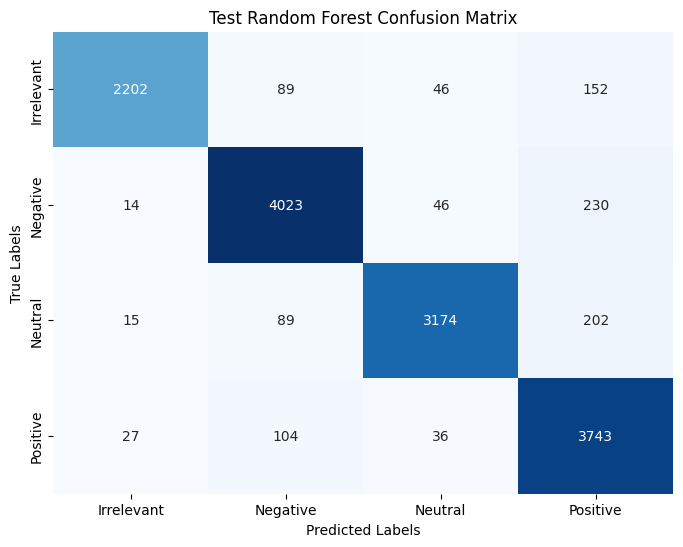

In [62]:
# Predict on the testing data
y_pred_encoded  = best_rf.predict(x_test_tfidf)
y_pred = le.inverse_transform(y_pred_encoded)

evaluate_model(y_test, y_pred, "Test Random Forest")

## Step 6.2 Validate Random Forest

Validation Random Forest weighted F1 score: 0.9659554764530536
Validation Random Forest Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.98      0.95      0.96       171
    Negative       0.97      0.96      0.96       266
     Neutral       0.98      0.97      0.97       285
    Positive       0.95      0.98      0.97       277

    accuracy                           0.97       999
   macro avg       0.97      0.96      0.97       999
weighted avg       0.97      0.97      0.97       999



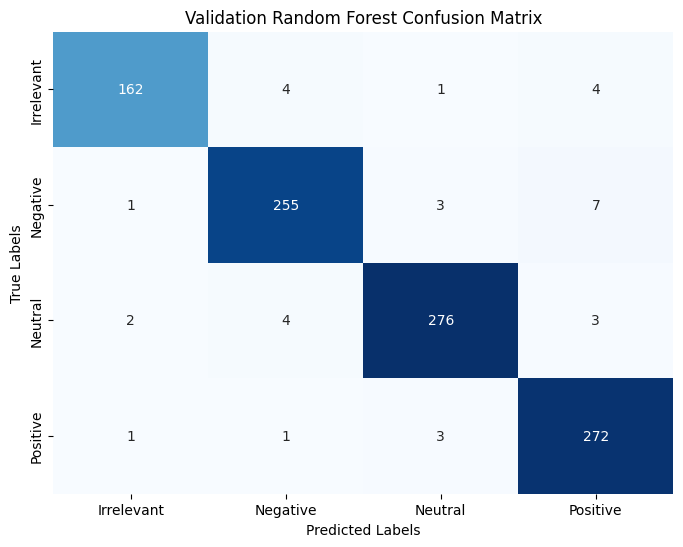

In [65]:
y_validation_pred_encoded  = best_rf.predict(x_validation_tfidf)
y_validation_pred = le.inverse_transform(y_validation_pred_encoded)
evaluate_model(y_validation, y_validation_pred, "Validation Random Forest")

In [64]:
if SAVE_MODELS:
    joblib.dump(best_rf, './models/best_random_forest.pkl')

## Step 6.3 Feature Selection

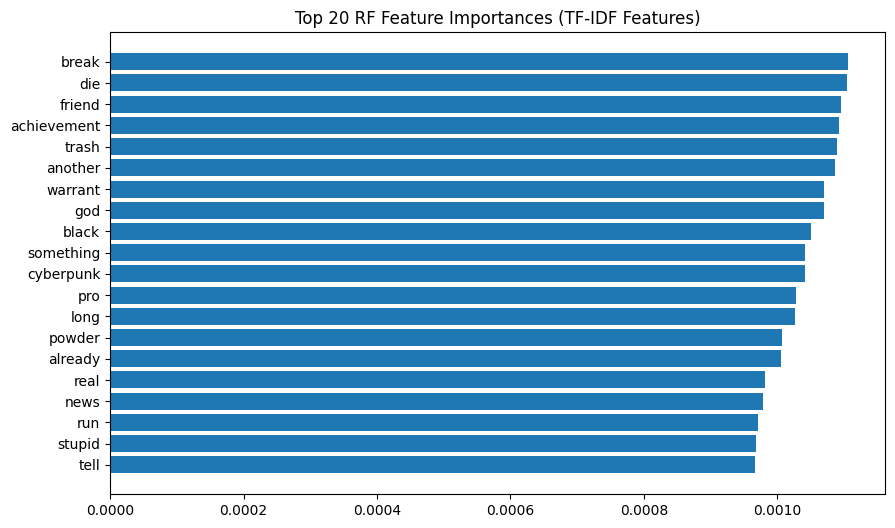

In [63]:
rf_importances = best_rf.feature_importances_
feature_names = vectorizer.get_feature_names_out()

# Sort feature importances in descending order
indices = np.argsort(rf_importances)[::-1]

# Plot the top 20 most important features
plt.figure(figsize=(10, 6))
plt.title("Top 20 RF Feature Importances (TF-IDF Features)")
plt.barh(range(20), rf_importances[indices][150:170], align='center')
plt.yticks(range(20), [feature_names[i] for i in indices[150:170]])
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()

The top 20 feature importance of the random tree classifier also show promising results, being able to capture negative sentiment words like “die”, “trash”, and “stupid”.
  
The feature selection is performed using SKLearn’s **SelectFromModel** library and the Random Tree Classifier feature importance. After several rounds of tests, the optimum threshold for  SelectFromModel is determined to be **0.000037**.

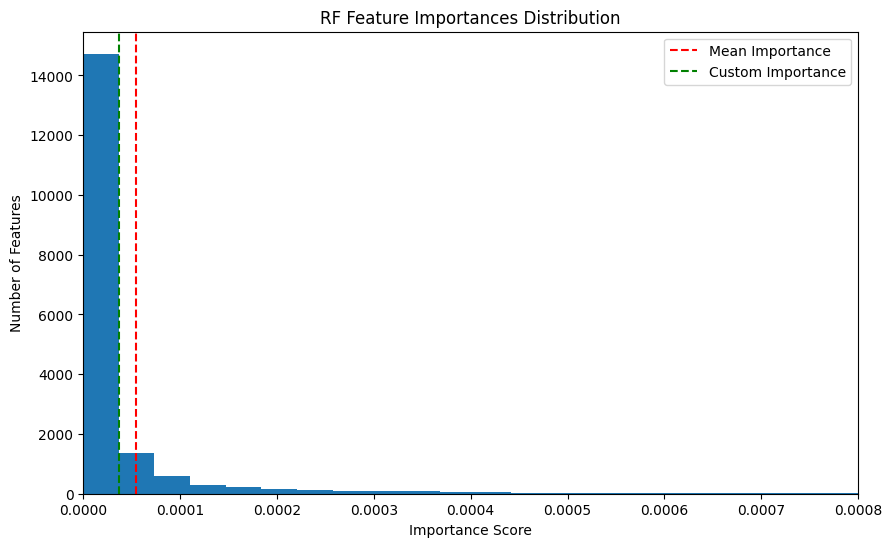

In [66]:
importances = best_rf.feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.hist(importances, bins=200)
plt.title('RF Feature Importances Distribution')
plt.xlabel('Importance Score')
plt.ylabel('Number of Features')
plt.axvline(np.mean(importances), color='r', linestyle='--', label='Mean Importance')
plt.axvline(0.000037, color='g', linestyle='--', label='Custom Importance')
plt.xlim(0, 0.0008)
plt.legend()
plt.show()

In [67]:
if LOAD_MODELS:
    sfm = joblib.load('./models/sfm.pkl')
else:
    threshold = 0.000036
    sfm = SelectFromModel(best_rf, prefit=True, threshold=threshold)

# Transform the dataset to only keep the most important features
x_train_tfidf_transformed = sfm.transform(x_train_tfidf)
x_test_tfidf_transformed = sfm.transform(x_test_tfidf)

In [68]:
# Get the selected feature indices
selected_features_indices = sfm.get_support(indices=True)

# Optionally, you can retrieve the feature names
selected_feature_names = vectorizer.get_feature_names_out()[selected_features_indices]

print("Selected Features:", selected_feature_names)
print("Number of Selected Features:", x_train_tfidf_transformed.shape[1])

Selected Features: ['ab' 'abandon' 'ability' ... 'zombie' 'zone' 'zoom']
Number of Selected Features: 3607


Using this threshold, the number of vocabulary in the training dataset was filtered from 18279 to 3542  
an **82.62%** reduction of the training dataset vocabulary.

## Step 6.4 Re-Train Data Using Feature Selection

In [69]:
if LOAD_MODELS:
    fine_tuned_svc = joblib.load('./models/fine_tuned_svc.pkl')
else:
    fine_tuned_svc = SVC(kernel='rbf', gamma='scale', class_weight='balanced', C=10)
    fine_tuned_svc.fit(x_train_tfidf_transformed, y_train_encoded)

Test SVC weighted F1 score: 0.894708276854146
Test SVC Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.90      0.87      0.88      2489
    Negative       0.93      0.91      0.92      4313
     Neutral       0.84      0.91      0.87      3480
    Positive       0.91      0.89      0.90      3910

    accuracy                           0.89     14192
   macro avg       0.89      0.89      0.89     14192
weighted avg       0.90      0.89      0.89     14192



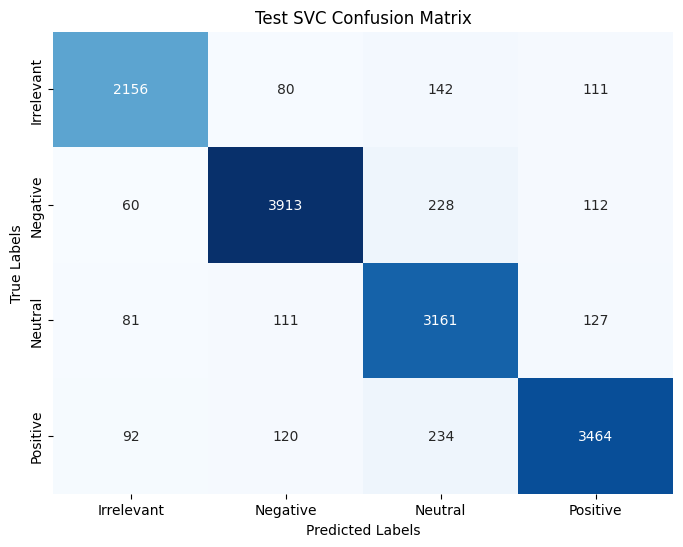

In [70]:
# Predict on the testing data
y_pred_encoded  = fine_tuned_svc.predict(x_test_tfidf_transformed)
y_pred = le.inverse_transform(y_pred_encoded)

evaluate_model(y_test, y_pred, "Test SVC")

In [71]:
if SAVE_MODELS:
    joblib.dump(sfm, './models/sfm.pkl')
    joblib.dump(fine_tuned_svc, './models/fine_tuned_svc.pkl')

# Step 7 Validate Fine-Tuned Model

Validation SVC weighted F1 score: 0.9619568592785075
Validation SVC Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.95      0.95      0.95       171
    Negative       0.96      0.96      0.96       266
     Neutral       0.96      0.97      0.96       285
    Positive       0.97      0.97      0.97       277

    accuracy                           0.96       999
   macro avg       0.96      0.96      0.96       999
weighted avg       0.96      0.96      0.96       999



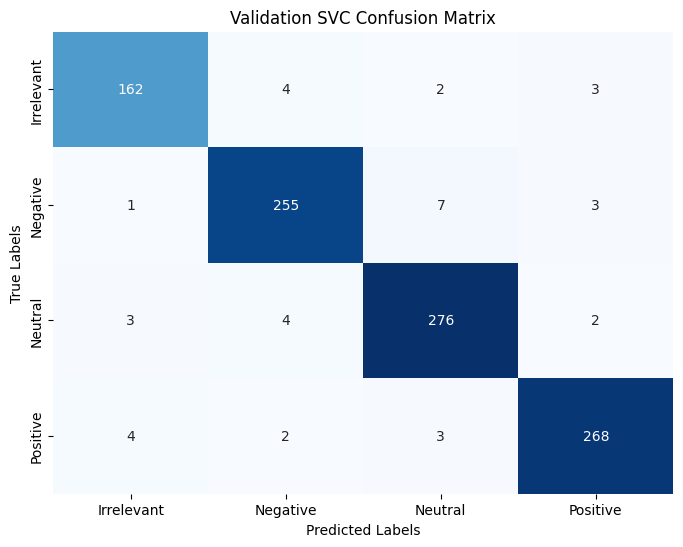

In [72]:
x_validation_tfidf_transformed = sfm.transform(x_validation_tfidf)
y_validation_pred_encoded  = fine_tuned_svc.predict(x_validation_tfidf_transformed)
y_validation_pred = le.inverse_transform(y_validation_pred_encoded)
evaluate_model(y_validation, y_validation_pred, "Validation SVC")

# Step 8 Original vs Fine-Tuned SVC Model

In [73]:
start_time = time.time()
y_pred_encoded  = best_svc.predict(x_test_tfidf)
end_time = time.time()
prediction_time = end_time - start_time
print(f"Original Test SVC Prediction Time: {prediction_time:.4f} seconds")

y_pred = le.inverse_transform(y_pred_encoded)
evaluate_model(y_test, y_pred, "Original Test SVC", False)

start_time = time.time()
y_pred_encoded  = fine_tuned_svc.predict(x_test_tfidf_transformed)
end_time = time.time()
prediction_time = end_time - start_time
print(f"Fine-Tuned Test SVC Prediction Time: {prediction_time:.4f} seconds")

y_pred = le.inverse_transform(y_pred_encoded)
evaluate_model(y_test, y_pred, "Fine-Tuned Test SVC", False)

Original Test SVC Prediction Time: 81.1465 seconds
Original Test SVC weighted F1 score: 0.9163933652977819
Original Test SVC Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.94      0.89      0.92      2489
    Negative       0.94      0.92      0.93      4313
     Neutral       0.93      0.91      0.92      3480
    Positive       0.87      0.94      0.90      3910

    accuracy                           0.92     14192
   macro avg       0.92      0.91      0.92     14192
weighted avg       0.92      0.92      0.92     14192

Fine-Tuned Test SVC Prediction Time: 68.0113 seconds
Fine-Tuned Test SVC weighted F1 score: 0.894708276854146
Fine-Tuned Test SVC Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.90      0.87      0.88      2489
    Negative       0.93      0.91      0.92      4313
     Neutral       0.84      0.91      0.87      3480
    Positive       0.91      0.89      0.90    

In [74]:
start_time = time.time()
y_validation_pred_encoded  = best_svc.predict(x_validation_tfidf)
end_time = time.time()
prediction_time = end_time - start_time
print(f"Original Validation SVC Prediction Time: {prediction_time:.4f} seconds")

y_validation_pred = le.inverse_transform(y_validation_pred_encoded)
evaluate_model(y_validation, y_validation_pred, "Original Validation SVC", False)

start_time = time.time()
y_validation_pred_encoded  = fine_tuned_svc.predict(x_validation_tfidf_transformed)
end_time = time.time()
prediction_time = end_time - start_time
print(f"Fine-Tuned Validation SVC Prediction Time: {prediction_time:.4f} seconds")

y_validation_pred = le.inverse_transform(y_validation_pred_encoded)
evaluate_model(y_validation, y_validation_pred, "Fine-Tuned Validation SVC", False)

Original Validation SVC Prediction Time: 5.6077 seconds
Original Validation SVC weighted F1 score: 0.9679737563000764
Original Validation SVC Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.96      0.96      0.96       171
    Negative       0.97      0.97      0.97       266
     Neutral       0.97      0.97      0.97       285
    Positive       0.96      0.97      0.96       277

    accuracy                           0.97       999
   macro avg       0.97      0.97      0.97       999
weighted avg       0.97      0.97      0.97       999

Fine-Tuned Validation SVC Prediction Time: 5.5828 seconds
Fine-Tuned Validation SVC weighted F1 score: 0.9619568592785075
Fine-Tuned Validation SVC Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.95      0.95      0.95       171
    Negative       0.96      0.96      0.96       266
     Neutral       0.96      0.97      0.96       285
    Positive

Overall, the feature selection has been very effective in significantly reducing the number of features/vocabulary by 82,62% while maintaining high performance.   
  
There is a small reduction in the model’s performance: a slight decrease in the overall Weighted F1-Score in the test dataset and a minimal decrease in the overall Weighted F1-Score in the validation dataset.
  
However, this accuracy reduction comes with a compelling trade-off: **a significant reduction in model complexity and a 20-25% improvement in prediction time.** Faster prediction time is especially beneficial for datasets like Twitter posts, which generate an enormous amount of data daily and can lead to significant time savings.   